# Ungraded Lab: Build a Multi-output Model

In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

## Imports

In [10]:
# !pip install xlrd openpyxl

     |████████████████████████████████| 243 kB 339 kB/s eta 0:00:01


In [3]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split


In [5]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [12]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [37]:
# Get the data from UCI dataset
URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URL, engine='openpyxl')
df = df.drop(columns=['Unnamed: 10', 'Unnamed: 11'])
df = df.dropna(how='all')
df 

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2.0,0.0,0.0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3.0,0.0,0.0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4.0,0.0,0.0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5.0,0.0,0.0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2.0,0.0,0.0,20.84,28.28
...,...,...,...,...,...,...,...,...,...,...
763,0.64,784.0,343.0,220.50,3.5,5.0,0.4,5.0,17.88,21.40
764,0.62,808.5,367.5,220.50,3.5,2.0,0.4,5.0,16.54,16.88
765,0.62,808.5,367.5,220.50,3.5,3.0,0.4,5.0,16.44,17.11
766,0.62,808.5,367.5,220.50,3.5,4.0,0.4,5.0,16.48,16.61


In [38]:

df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
647,0.69,735.0,294.0,220.5,3.5,2.0,0.25,1.0,12.78,15.21
177,0.66,759.5,318.5,220.5,3.5,3.0,0.25,3.0,13.01,15.80
226,0.69,735.0,294.0,220.5,3.5,3.0,0.10,2.0,11.46,13.54
491,0.79,637.0,343.0,147.0,7.0,2.0,0.25,2.0,38.57,43.86
198,0.64,784.0,343.0,220.5,3.5,3.0,0.40,5.0,18.19,20.21
...,...,...,...,...,...,...,...,...,...,...
607,0.76,661.5,416.5,122.5,7.0,2.0,0.25,4.0,36.95,37.20
273,0.86,588.0,294.0,147.0,7.0,2.0,0.40,3.0,31.28,35.22
60,0.82,612.5,318.5,147.0,7.0,2.0,0.10,3.0,22.93,28.68
762,0.86,588.0,294.0,147.0,7.0,4.0,0.25,4.0,29.08,33.93


In [39]:
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
X1,614.0,0.764495,0.103672,0.62,0.69,0.74,0.82,0.98
X2,614.0,670.996743,86.083342,514.50,612.50,686.00,735.00,808.50
X3,614.0,316.704397,44.117559,245.00,294.00,318.50,343.00,416.50
X4,614.0,177.146173,44.925161,110.25,147.00,220.50,220.50,220.50
X5,614.0,5.238599,1.751390,3.50,3.50,3.50,7.00,7.00
X6,614.0,3.501629,1.120401,2.00,3.00,3.00,5.00,5.00
X7,614.0,0.232980,0.133864,0.00,0.10,0.25,0.40,0.40
X8,614.0,2.822476,1.549430,0.00,2.00,3.00,4.00,5.00


In [40]:
train_Y = format_output(train)
test_Y = format_output(test)
train_Y

(array([12.78 , 13.01 , 11.46 , 38.57 , 18.19 , 28.4  , 29.91 , 41.67 ,
        35.45 , 14.44 , 16.9  , 28.6  ,  7.1  , 15.55 , 28.37 , 36.9  ,
        39.04 , 36.96 , 24.63 ,  6.04 , 39.04 , 29.02 , 24.77 , 33.48 ,
        41.92 , 19.52 , 28.67 , 24.94 , 10.66 , 10.68 , 28.61 , 17.88 ,
        23.86 , 42.96 , 12.49 , 13.78 , 12.62 , 33.16 , 36.86 , 13.97 ,
        25.66 , 33.24 , 42.11 , 30.05 , 32.46 , 35.69 , 10.34 , 14.32 ,
        10.7  , 31.81 , 11.34 , 12.3  , 15.18 , 12.67 , 32.38 , 26.45 ,
        29.52 , 32.12 , 15.41 , 10.08 , 32.33 , 14.47 , 10.71 , 12.36 ,
        28.66 ,  6.81 , 10.7  , 29.6  , 17.35 , 15.09 , 15.2  , 28.52 ,
        24.35 , 12.63 , 15.09 , 30.   , 42.74 , 29.03 , 42.08 , 12.2  ,
        12.18 , 15.16 , 25.98 , 35.99 , 14.08 , 28.64 , 28.67 , 10.8  ,
        23.75 , 12.86 , 41.64 , 32.69 , 12.47 , 26.33 , 11.69 , 12.95 ,
        24.13 , 13.18 , 26.47 , 14.71 , 12.68 , 12.59 , 13.99 , 12.12 ,
        14.66 , 35.89 , 32.31 , 40.79 , 28.03 ,  6.01 , 11.69 , 

In [41]:

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)
norm_train_X

,X1,X2,X3,X4,X5,X6,X7,X8
647,-0.718569,0.743503,-0.514634,0.965023,-0.992697,-1.340260,0.127141,-1.176223
177,-1.007944,1.028111,0.040700,0.965023,-0.992697,-0.447722,0.127141,0.114574
226,-0.718569,0.743503,-0.514634,0.965023,-0.992697,-0.447722,-0.993402,-0.530825
491,0.246016,-0.394928,0.596035,-0.671031,1.005716,-1.340260,0.127141,-0.530825
198,-1.200861,1.312719,0.596035,0.965023,-0.992697,-0.447722,1.247684,1.405371
...,...,...,...,...,...,...,...,...
607,-0.043359,-0.110320,2.262038,-1.216382,1.005716,-1.340260,0.127141,0.759973
273,0.921226,-0.964144,-0.514634,-0.671031,1.005716,-1.340260,1.247684,0.114574
60,0.535392,-0.679536,0.040700,-0.671031,1.005716,-1.340260,-0.993402,0.114574
762,0.921226,-0.964144,-0.514634,-0.671031,1.005716,0.444815,0.127141,0.759973


## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [42]:
# Define model layers.
input_layer = Input(shape=(len(train.columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 128)          1152        input_3[0][0]                    
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 128)          16512       dense_6[0][0]                    
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 64)           8256        dense_7[0][0]                    
____________________________________________________________________________________________

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [49]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
# model.compile(optimizer=optimizer,
#               loss={'y1_output': 'mse', 'y2_output': 'mse'},
#               metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
#                        'y2_output': tf.keras.metrics.RootMeanSquaredError()})
model.compile(optimizer=optimizer,
              loss=['mse', 'mse'],
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


## Train the Model

In [51]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=50, batch_size=10, validation_data=(norm_test_X, test_Y))

Epoch 1/50
62/62 [==============================] - 0s 4ms/step - loss: 0.3673 - y1_output_loss: 0.1329 - y2_output_loss: 0.2344 - y1_output_root_mean_squared_error: 0.3645 - y2_output_root_mean_squared_error: 0.4842 - val_loss: 2.2580 - val_y1_output_loss: 0.3215 - val_y2_output_loss: 1.9365 - val_y1_output_root_mean_squared_error: 0.5670 - val_y2_output_root_mean_squared_error: 1.3916
Epoch 2/50
62/62 [==============================] - 0s 4ms/step - loss: 0.5077 - y1_output_loss: 0.1197 - y2_output_loss: 0.3880 - y1_output_root_mean_squared_error: 0.3460 - y2_output_root_mean_squared_error: 0.6229 - val_loss: 2.1089 - val_y1_output_loss: 0.8603 - val_y2_output_loss: 1.2486 - val_y1_output_root_mean_squared_error: 0.9275 - val_y2_output_root_mean_squared_error: 1.1174
Epoch 3/50
62/62 [==============================] - 0s 4ms/step - loss: 0.2979 - y1_output_loss: 0.1066 - y2_output_loss: 0.1913 - y1_output_root_mean_squared_error: 0.3265 - y2_output_root_mean_squared_error: 0.4374 - v

Epoch 22/50
62/62 [==============================] - 0s 4ms/step - loss: 0.3203 - y1_output_loss: 0.1010 - y2_output_loss: 0.2193 - y1_output_root_mean_squared_error: 0.3178 - y2_output_root_mean_squared_error: 0.4683 - val_loss: 0.9453 - val_y1_output_loss: 0.2470 - val_y2_output_loss: 0.6983 - val_y1_output_root_mean_squared_error: 0.4970 - val_y2_output_root_mean_squared_error: 0.8356
Epoch 23/50
62/62 [==============================] - 0s 4ms/step - loss: 0.3438 - y1_output_loss: 0.0943 - y2_output_loss: 0.2495 - y1_output_root_mean_squared_error: 0.3070 - y2_output_root_mean_squared_error: 0.4995 - val_loss: 1.3911 - val_y1_output_loss: 0.2348 - val_y2_output_loss: 1.1564 - val_y1_output_root_mean_squared_error: 0.4845 - val_y2_output_root_mean_squared_error: 1.0753
Epoch 24/50
62/62 [==============================] - 0s 4ms/step - loss: 0.3114 - y1_output_loss: 0.0971 - y2_output_loss: 0.2142 - y1_output_root_mean_squared_error: 0.3116 - y2_output_root_mean_squared_error: 0.4629 

Epoch 43/50
62/62 [==============================] - 0s 4ms/step - loss: 0.2967 - y1_output_loss: 0.0900 - y2_output_loss: 0.2067 - y1_output_root_mean_squared_error: 0.3000 - y2_output_root_mean_squared_error: 0.4546 - val_loss: 0.9233 - val_y1_output_loss: 0.2764 - val_y2_output_loss: 0.6468 - val_y1_output_root_mean_squared_error: 0.5258 - val_y2_output_root_mean_squared_error: 0.8042
Epoch 44/50
62/62 [==============================] - 0s 4ms/step - loss: 0.3444 - y1_output_loss: 0.1084 - y2_output_loss: 0.2360 - y1_output_root_mean_squared_error: 0.3293 - y2_output_root_mean_squared_error: 0.4858 - val_loss: 0.9863 - val_y1_output_loss: 0.2591 - val_y2_output_loss: 0.7272 - val_y1_output_root_mean_squared_error: 0.5090 - val_y2_output_root_mean_squared_error: 0.8528
Epoch 45/50
62/62 [==============================] - 0s 4ms/step - loss: 0.4798 - y1_output_loss: 0.1262 - y2_output_loss: 0.3536 - y1_output_root_mean_squared_error: 0.3552 - y2_output_root_mean_squared_error: 0.5947 

## Evaluate the Model and Plot Metrics

In [52]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

5/5 [==============================] - 0s 3ms/step - loss: 0.8957 - y1_output_loss: 0.2426 - y2_output_loss: 0.6531 - y1_output_root_mean_squared_error: 0.4926 - y2_output_root_mean_squared_error: 0.8082
Loss = 0.8957459926605225, Y1_loss = 0.24263042211532593, Y1_mse = 0.4925752878189087, Y2_loss = 0.6531156301498413, Y2_mse = 0.8081557154655457


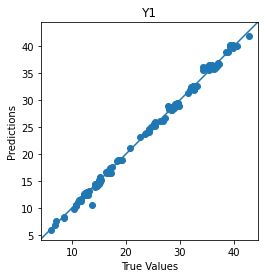

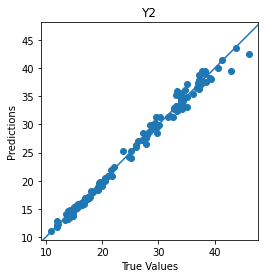

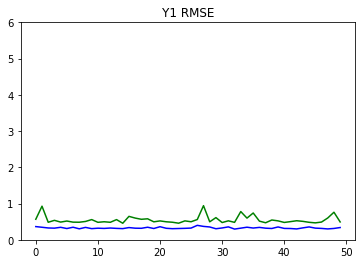

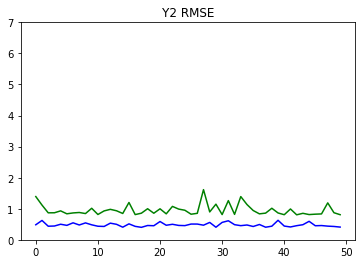

In [53]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)